**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1mgQaPN1eqhzNpTYTqbbXZHmolI7d2yll?usp=sharing)

2. Практика 1

3. [Практика 2](https://colab.research.google.com/drive/1sLGgmGkPLr5-ZLJM6vNLs7rQH29rbSUZ?usp=sharing)

Привет!

Это первый из двух практических ноутбуков по теме **Автокодировщики**. <br>

Здесь вы:
* построите модель автокодировщика;
* обучите его на картинках цифр (база `mnist`);
* посмотрите, что получится, если подать на вход обученной модели другие картинки (изображения одежды, база `fashion_mnist`);
* попробуете угадать порог ошибки автоэнкодера, отделяющий нормальные данные (картинки цифр) от выбросов (картинки с одеждой);
* напишите алгоритм, подбирающий оптимальный порог;
* построите и обучите модель с двумерным латентным пространством;
* визуализируете латентное пространство.

#Автокодировщики: архитектура, теория и визуализация


В этом разделе будет рассмотрено решение задачи определения выбросов среди изображений цифр и одежды, где цифры считаются нормальными изображениями, а изображения с одеждой – выбросами.

##Импорт библиотек

Первым делом импортируйте необходимые библиотеки и инструменты для работы с НС. 

In [ ]:
# Работа с операционной системой
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Отрисовка графиков
import matplotlib.pyplot as plt 

%matplotlib inline

Особенность этого урока в написании собственного callback. Для этого импортируйте `LambdaCallback` из `tensorflow.keras.callbacks`.

##Архитектура автокодировщика

Теперь, когда все инструменты у вас подгружены, пропишите архитектуру автокодировщика. Удобнее всего выделить создание модели в отдельную функцию, чтобы потом ее вызывать, а не создавать заново.

Ранее модели создавались через API `Sequential()` и последующее добавление в него слоев методом `.add(...)`. Но это не единственный способ создания модели. Сегодня будет  рассмотрен еще один – `Model` API (или Functional API). 

Функциональный API Keras - это способ создания моделей, более гибких, чем API `Sequential`. Функциональный API может обрабатывать модели с нелинейной топологией, общими слоями и даже с несколькими входами или выходами. Также этот способ позволяет использовать части модели отдельно от нее, что актуально будет в данном уроке (в частности при визуализации латентного пространства).

Автоэнкодер будет состоять из двух блоков энкодера и двух блоков декодера.

Вначале в переменную **inputs** определите входные данные и их размерность **in_shape** через слой **Input**.

Так как вы работаете с изображением, используйте в энкодере слои свертки **Conv2D** и слои снижения размерности **MaxPooling2D**. Блоки в энкодере идентичны (как бы отзеркаливают друг друга в плане архитектуры), кроме одного момента. 

Состав блока:

1. Двумерная свертка.
2. Нормализация.
3. Двумерная свертка.
4. Нормализация.
5. Снижение размерности.

Каждый блок завершается слоем **MaxPooling2D**, который уменьшает размерность данных. Но в первом блоке запись будет выглядеть так: 

`x = MaxPooling2D()(x)`

А во втором блоке:

`z = MaxPooling2D()(x)` 

Вектор скрытого пространства выделен отдельной переменной **z** только чтобы легче было понять, где в архитектуре латентное пространство.

Дальше идут два похожих друг на друга блока декодера, представляющие собой обратные действия для энкодера. В энкодере вы снизили размерность при помощи слоя **MaxPooling2D**, теперь надо развернуть скрытое пространство обратно. Для этого используйте слой **Conv2DTranspose**.

Состав блока:
1. Повышение размерности.
2. Нормализация.
3. Двумерная свертка.
4. Нормализация
5. Двумерная свертка.
6. Нормализация.

После двух блоков декодера идет финальный слой двумерной свертки декодера, который выдает итоговое изображение. Прописав структуру автокодировщика, вам остается собрать ее `model = Model(inputs, outputs)`, в которой на вход подается оригинальное изображение, а на выходе – изображение после сжатия и его восстановления. Компилируйте сеть, используя оптимизатор **Adam** и ошибку **mse**.

Так как модель создана в функции, ее нужно вернуть посредством `return model`.


In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)
    
    
    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)
        

    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x) 
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x) 
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.6. Нормализация
    x = BatchNormalization()(x) 

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') 

    # Возврат готовой модели
    return model 

В этой теме вводится понятие *латентного* (скрытого) *пространства* . Латентное пространство – пространство чисел, в рамках которого мы пытаемся выделить ключевые признаки объектов. Каждый объект на входе (изображение, например) преобразуется энкодером в тензор в скрытом пространстве. Декодер же из этого тензора пытается реконструировать исходный объект.

###Сервисные функции

Теперь пропишите еще одну функцию `plot_images(x_data, pred, shape=None, n=5)`, которая выведет **n** – количество изображений каждого типа. У функции четыре параметра:
* **x_data** – оригинальные изображения;
* **pred** – изображения после автокодировщика;
* **n** – количество изображений каждого типа.

Для визуализации можно использовать `plt`. <br>
При одноканальных изображениях этот фреймворк требует убирать уже лишнюю ось каналов, так как она всего одна, поэтому избыточна. То есть сделать преобразование формы тензора $(28, 28, 1) \rightarrow (28, 28)$.
Это можно сделать функцией `.squeeze(axis=-1)`. Если не указать ось, то автоматически будут убраны все оси единичного размера. 

Чтобы вывести изображение, нужно полотно. Объявите его и задайте размер `plt.figure(figsize=(14, 7))`.

Так как у вас идет визуальное сравнение двух наборов изображений по пять штук каждого, то их нужно вывести. Если описывать вывод каждого, это займет много строк кода. Поэтому создайте цикл, в котором пройдетесь по каждому изображению:
* Возьмите случайное число от 0 до `pred.shape[0]`, что будет индексом будущего изображения.
* Рассчитайте, где должна находится картинка `ax = plt.subplot(2, n, i + 1)`.
* Обозначьте, какая картинка должна быть показана, ее размер и то, что она должна быть в серых тонах.
* Отключите показ линий координат строками `ax.get_xaxis().set_visible(False)` и `ax.get_yaxis().set_visible(False)`.

В общем виде `plt.subplot(nrows, ncols, index)`. Первый аргумент `nrows` – общее число строк в полотне, `ncols` – число столбцов, `index` – индекс, порядковый номер рисунка в этой сетке. Последний начинается с 1. Рост порядкового номера идет слева направо, сверху вниз. То есть индексация рисунков на полотне выглядит так:
$$
\left(
\begin{array}{cccc}
1 & 2 & 3 & 4 & 5\\
6 & 7 & 8 & 9 & 10
\end{array}
\right)
$$

Завершите функцию строкой кода `plt.show()`, чтобы вывести изображения на экран.


In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Как вы уже знаете, для сравнения результатов автокодировщика нужно сравнить исходное изображение и изображение после НС. Для этого используйте функцию *mean_squared_error* на простых примерах, взятых "с потолка":

In [ ]:
# Иллюстрация работы функции mean_squared_error (mse)
print(mean_squared_error([1, 1, 1], [1, 1, 1]))
print(mean_squared_error([1, 1, 1, 1], [1, 1, 0, 0]))

0.0
0.5


Как видите в первом примере, наборы данных идентичны и соответственно результат функции равен 0. Во втором примере только 50% данных совпадает, а потому ошибка больше.

Теперь, когда вы сделали все подготовительные работы, решите практическую задачу.


###Обучение автокодировщика на датасете MNIST



Без набора данных не проходит ни одно обучение НС. Так как вы работаете с изображениями цифр, загрузите данные `mnist.load_data()`.

In [ ]:
# Загрузка данных из базы с готовой разбивкой на train/test
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


Теперь ваши данные нужно привести в удобный для НС формат. Так как вы работаете с изображением, а слой **Conv2D** работает с двумерными данными + каналы, добавьте еще одну размерность: `.reshape(-1, 28, 28, 1)`.

In [ ]:
# Приведение всех картинок к нужной форме
x_train_mnist_ = x_train_mnist.reshape(-1, x_train_mnist.shape[1], x_train_mnist.shape[2], 1)
x_test_mnist = x_test_mnist.reshape(-1, x_test_mnist.shape[1], x_test_mnist.shape[2], 1)

Что значит в `reshape` аргумент `-1`? При преобразовании тензора формы (60000, 28, 28) для добавления еще одной оси в конце мы можем задать новую форму как (60000, 28, 28, 1), а можем – (-1, 28, 28, 1), что будет тем же самым для того же тензора. То есть `-1` означает, что данная ось должна быть такого размера, чтобы все значения в тензоре сохранились. <br> 
Проще говоря `-1` позволяет нам как бы не задумываться, какой там размер у оси (то есть сколько в батче объектов), если мы знаем размер всех остальных осей.

Далее рекомендуется перевести целочисленные данные в вещественные.

In [ ]:
# Приведение всех картинок к нужному типу
x_train_mnist = x_train_mnist_.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')

НС лучше работает с данными в диапазоне от 0 до 1, поэтому приведите их к нему с помощью `.astype('float32') / 255`. 

In [ ]:
# Нормализация пикселей в диапазон [0,1]
x_train_mnist /= 255.
x_test_mnist /= 255.

Перевод данных к вещественному типу нужен для того, чтобы избежать потерь точности при последующих расчетах, при которых числа все равно преобразуются в вещественные, но уже с потерями.

Сравните, насколько отличается вариант данных, где вы переводите данные в тип `'float32'` и где не переводите.

In [ ]:
delta = ((x_train_mnist_.astype('float32') / 255.) - (x_train_mnist_ / 255.))
print("Средняя разница:", delta.mean())
print("Максимальная разница:", delta.max())

Средняя разница: 1.128567261525458e-09
Максимальная разница: 2.9685450542160652e-08


Теперь, когда данные готовы для НС, проверьте их размерность:

In [ ]:
# Проверка формы данных
print(x_train_mnist.shape)
print(x_test_mnist.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(x_train_mnist.shape[1:])

Данные готовы! Соберите вашу модель НС при помощи ранее созданной функции и передайте в нее необходимую вам размерность. Выведите структуру НС на экран, чтобы оценить, как она выглядит:

In [ ]:
# Сводка архитектуры автокодировщика
ae_mnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

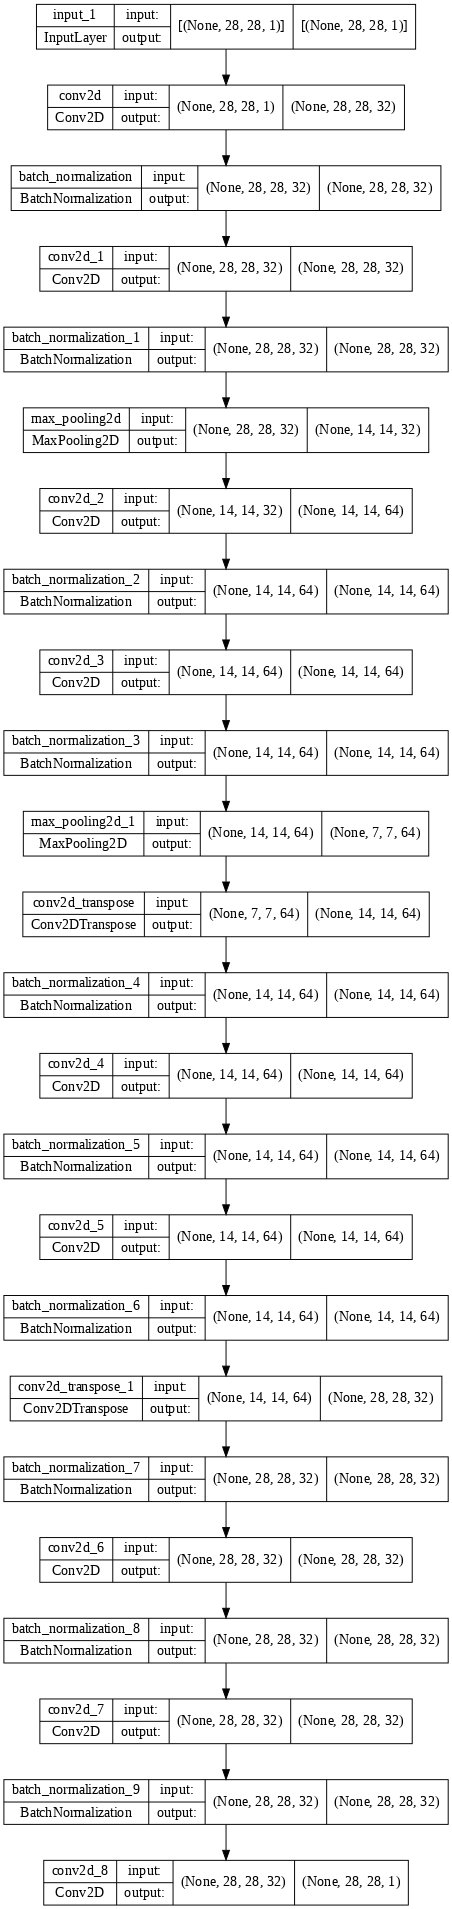

In [ ]:
# Визуальная схема архитектуры модели
utils.plot_model(ae_mnist, 
                 dpi=70,                  # число точек на дюйм (дюйм = 2.54 см)
                 show_shapes=True         # отображение ожидаемых форм входных и выходных тензоров каждого слоя
                 )

При отображении модели `dpi` выбран равным `70`, потому что нам показался наиболее удобным. Вы можете выбирать другое значение.

Теперь обучите автокодировщик. Особенность этого обучения в том, что вместо обычного набора данных **y_train** вы подаете тот же **x_train**. Для теста
 то же самое.

In [ ]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(x_train_mnist, x_train_mnist,
                       epochs=50,
                       batch_size=256,
                       validation_data = (x_test_mnist, x_test_mnist))

Epoch 1/50
235/235 [==============================] - 36s 96ms/step - loss: 0.0799 - val_loss: 0.1003
Epoch 2/50
235/235 [==============================] - 22s 95ms/step - loss: 0.0176 - val_loss: 0.0161
Epoch 3/50
235/235 [==============================] - 22s 92ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 4/50
235/235 [==============================] - 22s 93ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 5/50
235/235 [==============================] - 22s 93ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 6/50
235/235 [==============================] - 22s 92ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/50
235/235 [==============================] - 22s 93ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/50
235/235 [==============================] - 21s 91ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/50
235/235 [==============================] - 21s 91ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 10/50
235/235 [==============================] - 21s 91ms/step - loss: 0.002

Выведите на график ошибки по обучению и тесту.

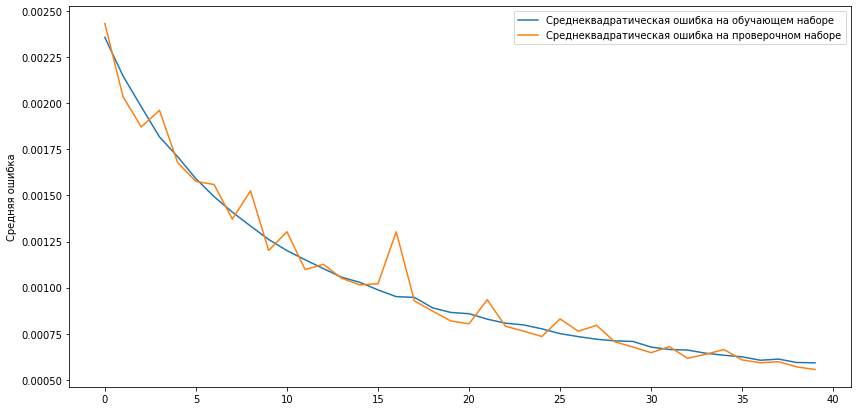

In [ ]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Результат хороший: ошибка уменьшается. Переобучение достаточно мало.

Сохраните и восстановите веса модели, чтобы можно было вернутся к этому результату НС. Для этого создайте путь к папке с моделями и создайте эту папку, если ее еще нет:

In [ ]:
# путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

`'ae_mnist.h5'` - имя сохраняемого файла.

Для сохранения модели используйте метод **.save_weights()**

Для загрузки модели из файла используйте метод **.load_weights()**

In [ ]:
# Сохранение/восстановление параметров модели
ae_mnist.save_weights(PATH + '/ae_mnist.h5') # Сохраняем модель
ae_mnist.load_weights(PATH + '/ae_mnist.h5') # Загружаем модель

Это один из способов сохранения результатов обучения на диск. Второй способ будет показан во второй практике.

Теперь, когда модель обучена, и результат обучения положительный, вы можете проверить работу НС.

###Проверка результатов

Получите предсказания на тренировочной и тестовой выборке при помощи `.predict()`:

In [ ]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train_mnist = ae_mnist.predict(x_train_mnist)
pred_test_mnist = ae_mnist.predict(x_test_mnist)

При помощи вспомогательной функции `plot_images`, которая описана в начале, выведите исходные изображения и изображения после автокодировщика. 

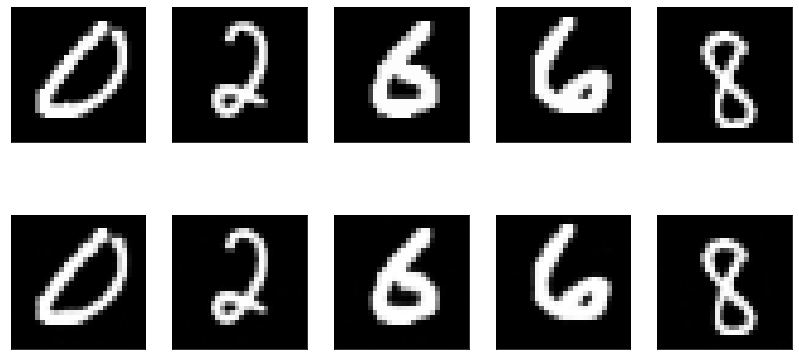

In [ ]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(x_test_mnist, pred_test_mnist)

Как видите, результат предсказания почти неотличим от оригинала.

Чтобы посчитать ошибку между двумя наборами данных:

* узнайте количество пикселей в картинке;
* сплющите вектора, так как функция `mean_squared_error()` ожидает двумерный вектор. Используйте `.reshape(-1, image_size).T`.

`.T` подразумевает транспонирование матрицы. Это когда в матрице строки и столбцы меняются местами, например:

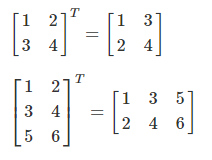

Иными словами матрица отражается относительно диагонали.

При расчете **mse** используется параметр `multioutput='raw_values'`. При расчете ошибки он определяет, сохранять ли список из поэлементного расчета. Если его не использовать, расчет выдаст единственную цифру.

Выведите результат на экран.

In [ ]:
# Расчет количества пикселей изображения
image_size = x_train_mnist.shape[1] * x_train_mnist.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train_mnist = mean_squared_error(x_train_mnist.reshape(-1, image_size).T, 
                                     pred_train_mnist.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test_mnist = mean_squared_error(x_test_mnist.reshape(-1, image_size).T,
                                    pred_test_mnist.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе MNIST: {err_train_mnist.mean()}')
print(f'Средняя ошибка на  тестовом наборе MNIST: {err_test_mnist.mean()}')

Средняя ошибка на обучающем наборе MNIST: 0.0005493385251611471
Средняя ошибка на  тестовом наборе MNIST: 0.0005548979970626533


Как видите, ошибка на тестовом наборе чуть больше, но это закономерно.

Теперь пришло время перейти к поиску выбросов.

###Определение выбросов



Загрузите набор данных **fashion_mnist**, приведите данные к нужной размерности и нормализуйте их (все как с изображениями цифр). 

In [ ]:
# Загрузка и предобработка данных fashion_mnist
(x_train_fashion_mnist, y_train_fashion_mnist), (x_test_fashion_mnist, y_test_fashion_mnist) = fashion_mnist.load_data()
x_train_fashion_mnist = x_train_fashion_mnist.reshape(-1, x_train_fashion_mnist.shape[1], x_train_fashion_mnist.shape[2], 1).astype('float32') / 255.
x_test_fashion_mnist = x_test_fashion_mnist.reshape(-1, x_test_fashion_mnist.shape[1], x_test_fashion_mnist.shape[2], 1).astype('float32') / 255.

4431872/4422102 [==============================] - 0s 0us/step


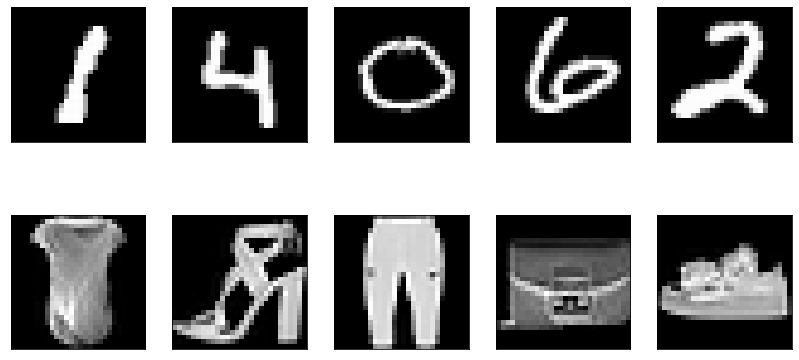

In [ ]:
# Сравнение примеров mnist и fashion_mnist: очень разные картинки
plot_images(x_train_mnist, x_train_fashion_mnist)

Как видите, картинки очень сильно отличаются. **mnist** – цифры, **fashion_mnist** – предметы одежды.

Почему используются изображения одежды в качестве выбросов?

> На самом деле не так важно, какие изображения использовать в качестве выбросов. Главная идея в том, что **любая цифра похожа на любую цифру больше, чем на любой предмет одежды.**

In [ ]:
# Получение предсказания автокодировщика на выборке fashion_mnist
pred_train_fashion_mnist = ae_mnist.predict(x_train_fashion_mnist)

Теперь на обученном автокодировщике предскажите картинки одежды и посмотрите на результат.

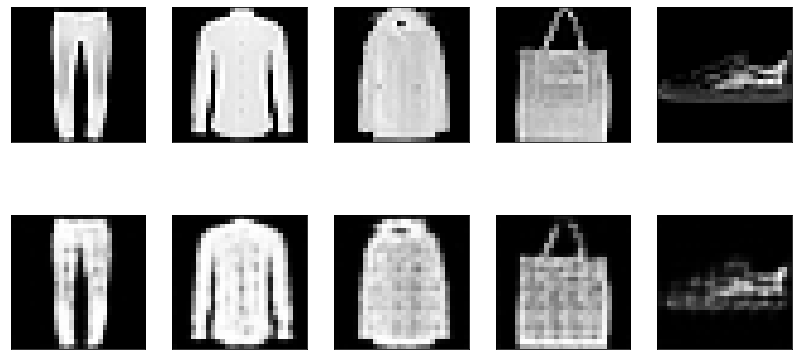

In [ ]:
# Сравнение исходных и восстановленных картинок из выборки fashion_mnist
plot_images(x_train_fashion_mnist, pred_train_fashion_mnist)

Предсказание далеко от идеала, но можно разобраться, что на нем изображено. И это при том, что НС никогда не видела эти данные.

Теперь посчитайте ошибку на предсказании одежды и сравните их с результатами цифр.

In [ ]:
# Сравнение среднеквадратических ошибок предсказания на mnist и fashion_mnist
err_train_fashion_mnist = mean_squared_error(x_train_fashion_mnist.reshape(-1, image_size).T,
                                             pred_train_fashion_mnist.reshape(-1, image_size).T,
                                             multioutput='raw_values')

print('Средняя ошибка на         MNIST: {:.5f}'.format(err_train_mnist.mean()))
print('Средняя ошибка на Fashion_MNIST: {:.5f}'.format(err_train_fashion_mnist.mean()))
print()
print('Максимальная ошибка на         MNIST: {:.5f}'.format(err_train_mnist.max()))
print('Минимальная  ошибка на Fashion_MNIST: {:.5f}'.format(err_train_fashion_mnist.min()))

Средняя ошибка на         MNIST: 0.00055
Средняя ошибка на Fashion_MNIST: 0.00749

Максимальная ошибка на         MNIST: 0.00397
Минимальная  ошибка на Fashion_MNIST: 0.00064


Какие выводы можно сделать по этим цифрам?
> * Пожалуй, самый главный: средняя ошибка на цифрах намного ниже, чем на одежде. 
> * Значит, теоретически, с помощью полученного автокодировщика можно вычислить бОльшую часть выбросов.
> * Максимальная ошибка на цифрах больше минимальной ошибки на одежде. Поэтому с такой моделью и обычным порогом не получится отделить всю одежду от цифр.

### Иллюстрация работы механизма поиска выбросов по порогу

Обозначьте вручную границу разделения `threshold`. Например, `0.0012`.

In [ ]:
# Ошибка выше порога - данные не из MNIST, т.е. выброс
threshold = 0.0014

Для большего понимания можно построить гистограмму ошибок на одном рисунке. 

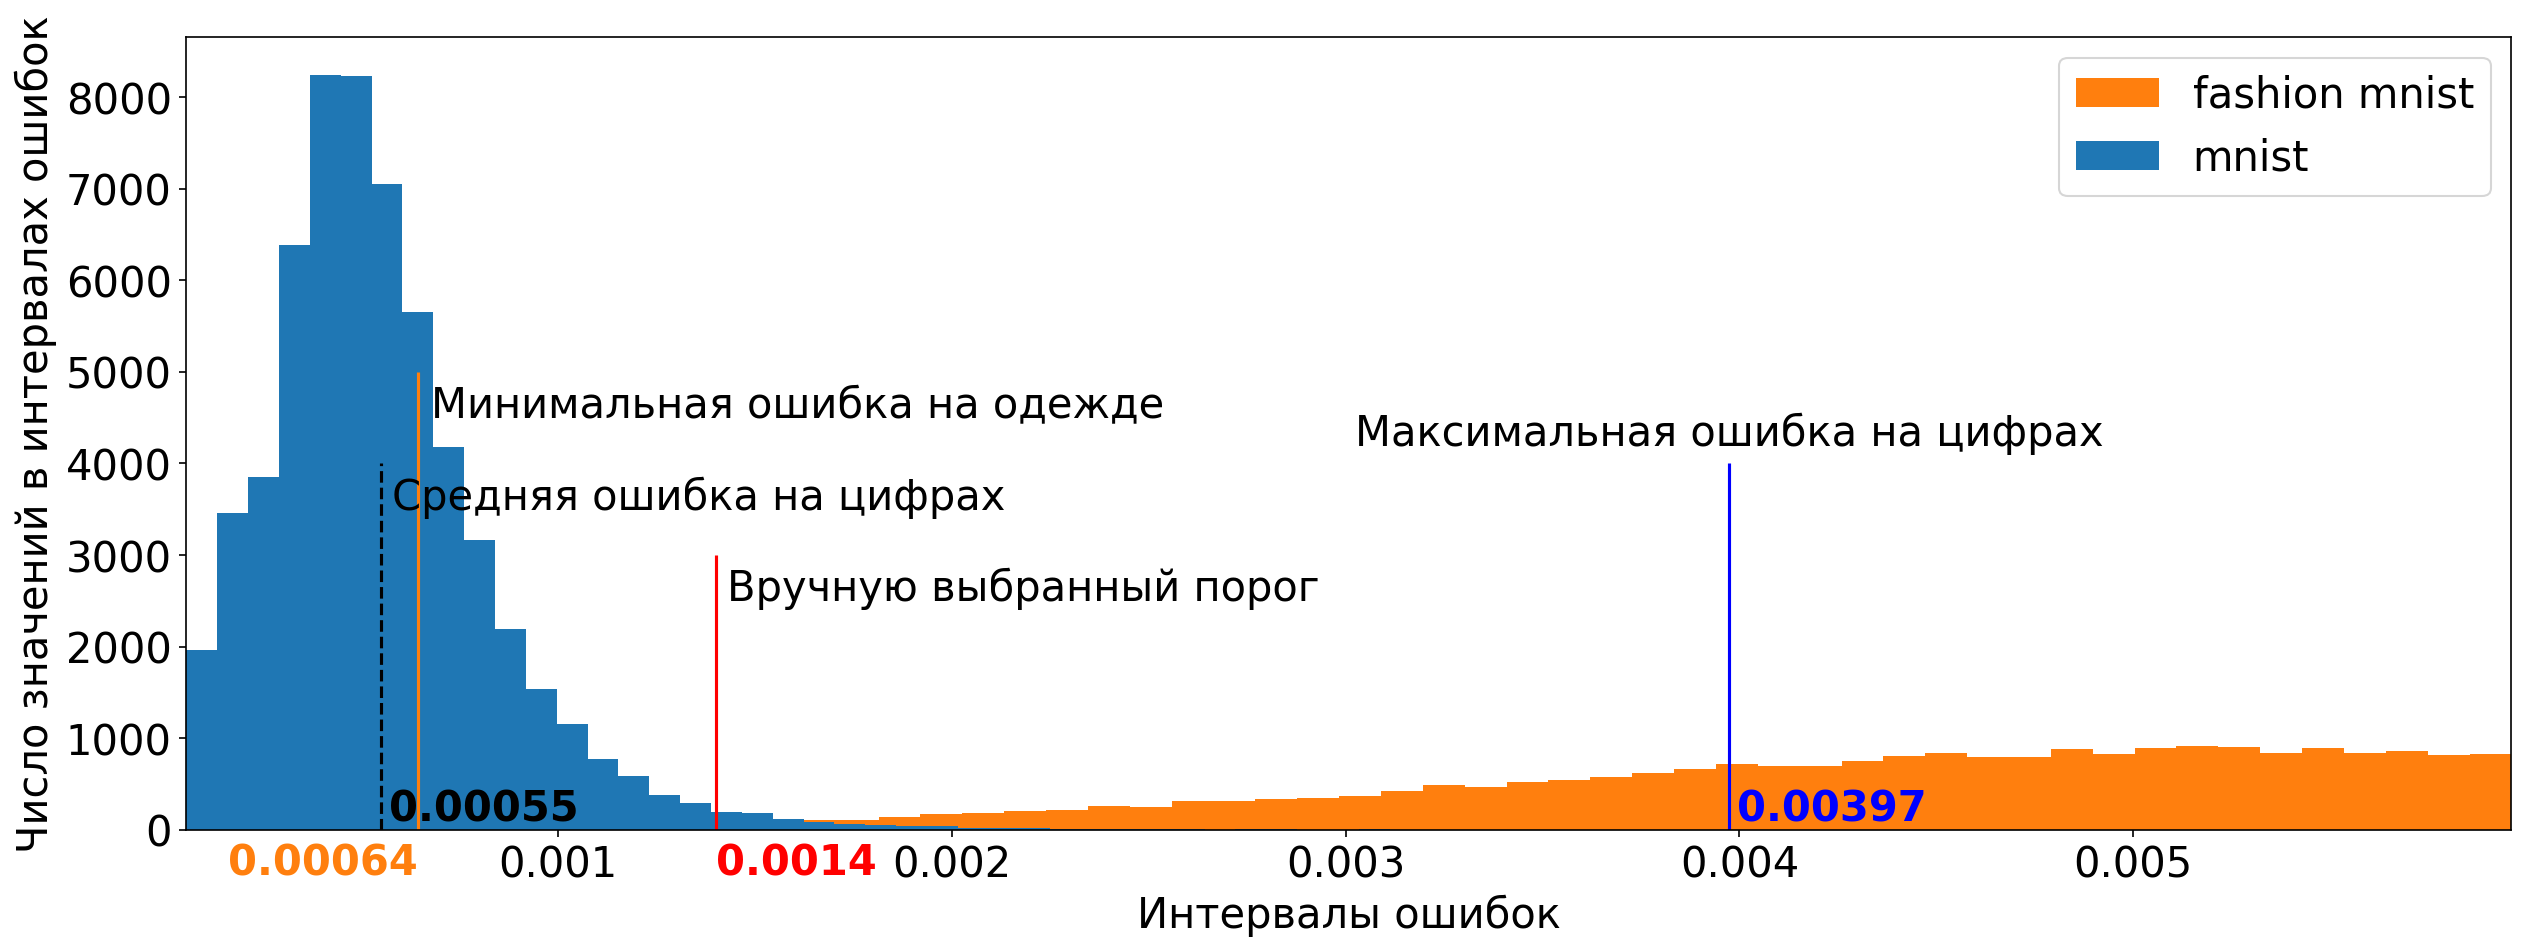

In [ ]:
# мы еще отрисуем гистограммы, когда получим оптимальный порог, поэтому
# чтобы не писать все дважды, обернем в функцию
def show_hist(threshold_hand=threshold, threshold_optimized=None):

  # для вывода определенного количества значений после запятой
  def toFixed(numObj, digits=5):
      return f"{numObj:.{digits}f}"

  # настраиваем размер шрифта для всего текста рисунка
  plt.rcParams['font.size'] = '20'

  # настраиваем рисунок
  plt.figure(dpi=150, # число точек на дюйм
            figsize=(20, 7)) # размер рисунка

  # определяем границы ошибки
  # если все отобразить, то гистограмма одежды займет почти все пространство
  # рисунка и гистограмму цифр уже будет плохо видно
  plt.xlim(err_train_mnist.min(), err_train_mnist.max()*1.5)

  # выбираем ошибки одежды в пределах выбранной границы
  err_fashion_slice = err_train_fashion_mnist[err_train_fashion_mnist < err_train_mnist.max()*1.5]

  # отрисовываем гистограммы одежды и цифр
  plt.hist(err_fashion_slice, bins=50, label='fashion mnist', color='tab:orange')
  plt.hist(err_train_mnist, bins=50, label='mnist')

  # на рисунок поместятся средняя и максимальная ошибки цифр и минимальная ошибка одежды
  errs = [err_train_mnist.mean(), err_train_mnist.max(), err_train_fashion_mnist.min()]

  # вертикальными линиями выделяем интересующие значения ошибок и порога
  plt.vlines(errs[0], 0, 4000, linestyles='dashed', colors='black')
  plt.vlines(errs[1], 0, 4000, linestyles='solid', colors='blue')
  plt.vlines(errs[2], 0, 5000, linestyles='solid', colors='tab:orange')
  plt.vlines(threshold_hand, 0, 3000, linestyles='solid', colors='r')

  # описание ошибок и порога
  plt.text(s='Средняя ошибка на цифрах', x=errs[0]*1.05, y=3500)
  plt.text(s='Минимальная ошибка на одежде', x=errs[2]*1.05, y=4500)
  plt.text(s='Максимальная ошибка на цифрах', x=errs[1], y=4200, fontdict={'ha': 'center'})
  plt.text(s='Вручную выбранный порог', x=threshold_hand*1.02, y=2500)

  # отрисовка значений
  plt.text(errs[0] + 2e-5, +100, toFixed(errs[0]), fontdict={'fontweight':'bold'})
  plt.text(errs[1] + 2e-5, 100, toFixed(errs[1]), fontdict={'ha': 'left', 'c':'blue', 'fontweight':'bold'})
  plt.text(errs[2], -500, toFixed(errs[2]), fontdict={'ha': 'right', 'c':'tab:orange','fontweight':'bold'})
  plt.text(threshold_hand, -500, toFixed(threshold_hand, 4), fontdict={'c':'red','fontweight':'bold'})

  if threshold_optimized:
    plt.vlines(threshold_optimized, 0, 2000, linestyles='solid', colors='r', linewidths=3.5)
    plt.text(s='Оптимальный порог', x=threshold_optimized*1.02, y=1500)
    plt.text(threshold_optimized + 2e-5, +200, toFixed(threshold_optimized, 4), fontdict={'c':'red','fontweight':'bold'})

  plt.ylabel('Число значений в интервалах ошибок')
  plt.xlabel('Интервалы ошибок')
  plt.legend()
  plt.show()

show_hist()

Гистограмма напоминает рисунок из теории. Только в нашем случае эти множественные выбросы не являются коллективными. Это точечные выбросы. Просто нам повезло, что их достаточно много.

Все левее порога считаем данными из mnist, все правее – данными из fashion_mnist (выбросы).

Отметьте все примеры, которые распознаны с ошибкой меньше порога. Выведите результаты на экран.

In [ ]:
# Отметка всех примеров, распознанных с ошибкой меньше порога, на mnist и fashion_mnist
is_ok_mnist = err_train_mnist < threshold
is_ok_fashion_mnist = err_train_fashion_mnist < threshold

# Расчет и вывод статистик
print('Распознано как норма на         MNIST: {:.2f}%'.format(100 * is_ok_mnist.mean()))
print('Распознано как норма на Fashion_MNIST: {:.2f}%'.format(100 * is_ok_fashion_mnist.mean()))
print('Суммарная ошибка: {:.2f}%'.format(100 * (1 - is_ok_mnist.mean() + is_ok_fashion_mnist.mean())))

Распознано как норма на         MNIST: 98.58%
Распознано как норма на Fashion_MNIST: 0.17%
Суммарная ошибка: 1.58%


Вручную неудобно искать порог, поэтому рассмотрите вариант определения оптимального порога.

###Определение оптимального порога

Напишите функцию поиска оптимального порога и вывода результата. 
Параметры функции:
* **err_true** – ошибка MSE на нормальных данных (цифры);
* **err_wrong** – ошибка MSE на выбросах (одежда);
* **points=1000** – количество проверяемых порогов;
* **factor = 2.** – параметр для подсчета максимального значения ошибки;
* **show=True** – выводить ли результаты на экран.

`.linspace()` возвращает одномерный массив из указанного количества элементов, значения которых равномерно распределены внутри заданного интервала.  То есть 1 000 значений между средним значением ошибки по положительным данным до увеличенной в два раза максимальной ошибки положительных данных.

Для расчетов нужны несколько пустых массивов, в которых для каждого порога будет рассчитана ошибка положительных данных, ошибка выбросов и суммарная ошибка.

В цикле пройдите по всей длине порога (1000 значений) и определите минимальную суммарную ошибку `.argmin(errors_overall)`, что и будет оптимальным порогом.

Дальше, при необходимости вывода графика и статистики, опишите все необходимые значения.


In [ ]:
# Функция поиска оптимального порога
def find_optimal_threshold(err_true, err_wrong, points=1000, factor = 2., show=True):
    
    # Сетка порогов между средней и кратной максимальной ошибками с малым шагом
    thresholds = np.linspace(err_true.mean(), factor * err_true.max(), points)
    
    # Массив значений ошибок для каждого значения порога
    errors_true = np.empty(thresholds.shape)
    errors_wrong = np.empty(thresholds.shape)
    errors_overall = np.empty(thresholds.shape)

    # Расчет ошибок на верных и неверных данных, общей ошибки
    # для каждого порога, и занесение ошибок в массивы
    for i in range(thresholds.shape[0]):
        errors_true[i] = 1 - (err_true < thresholds[i]).mean()
        errors_wrong[i] = (err_wrong < thresholds[i]).mean()
        errors_overall[i] = errors_true[i] + errors_wrong[i]
        
    # Определение индекса оптимального порога по минимальной общей ошибке
    optimal_i = np.argmin(errors_overall)

    # Если требуется, вывод картинки и статистик
    if show:
        plt.figure(figsize=(14,7))
        plt.plot(thresholds, errors_true, label='На верных данных')
        plt.plot(thresholds, errors_wrong, label='На выбросах')
        plt.plot(thresholds, errors_overall, label='Общая ошибка')
        plt.plot(thresholds[optimal_i], errors_overall[optimal_i], 'ro')
        plt.xlabel('Порог')
        plt.ylabel('Ошибки')
        plt.legend()
        plt.title('График ошибок при разных порогах')
        plt.show()

        print('Оптимальный порог: {:.4f}'.format(thresholds[optimal_i]))
        print('Распознано как норма на верных данных: {:.2f}%'.format(100 * (1 - errors_true[optimal_i])))
        print('Распознано как норма на выбросах     : {:.2f}%'.format(100 * errors_wrong[optimal_i]))
        print('Суммарная ошибка: {:.2f}%'.format(100 * errors_overall[optimal_i]))

    # Возврат оптимальных значений: индекс, значение порога и все ошибки
    return optimal_i, \
           thresholds[optimal_i], \
           errors_true[optimal_i], \
           errors_wrong[optimal_i], \
           errors_overall[optimal_i]

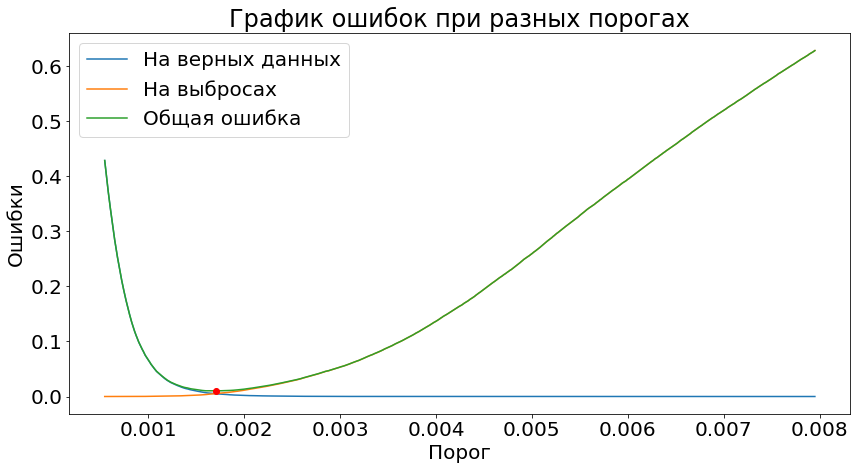

Оптимальный порог: 0.0017
Распознано как норма на верных данных: 99.50%
Распознано как норма на выбросах     : 0.53%
Суммарная ошибка: 1.03%


In [ ]:
# Определение оптимального порога для mnist и fashion_mnist
_, threshold_optimized, _, _, _  = find_optimal_threshold(err_train_mnist, err_train_fashion_mnist, factor=2.)

Как видим, с повышением порога ошибка на нормальных данных падает. И это логично. С увеличением порога все больше объектов нормальных данных становятся по левую сторону от порога, а значит, предсказываются как нормальные данные. **Ошибка на верных данных уменьшается.** И такая же ситуация с выбросами: с увеличением порога все больше выбросов подходят под этот критерий нормальных данных. **Ошибка на выбросах увеличивается.**. А нам нужно как можно больше данных распознать верно – как выбросов, так и нормальных данных. Поэтому мы находим оптимальный порог, обеспечивающий минимальную суммарную ошибку.

> `_ =` – данные сохраняются в никуда. Так обозначают, что данные, которые возвращает функция на текущий момент не нужны и не будут использоваться в дальнейшем. Хотя это почти такая же переменная, как и остальные.

Теперь снова отобразите гистограммы, но уже с добавлением нового порога.

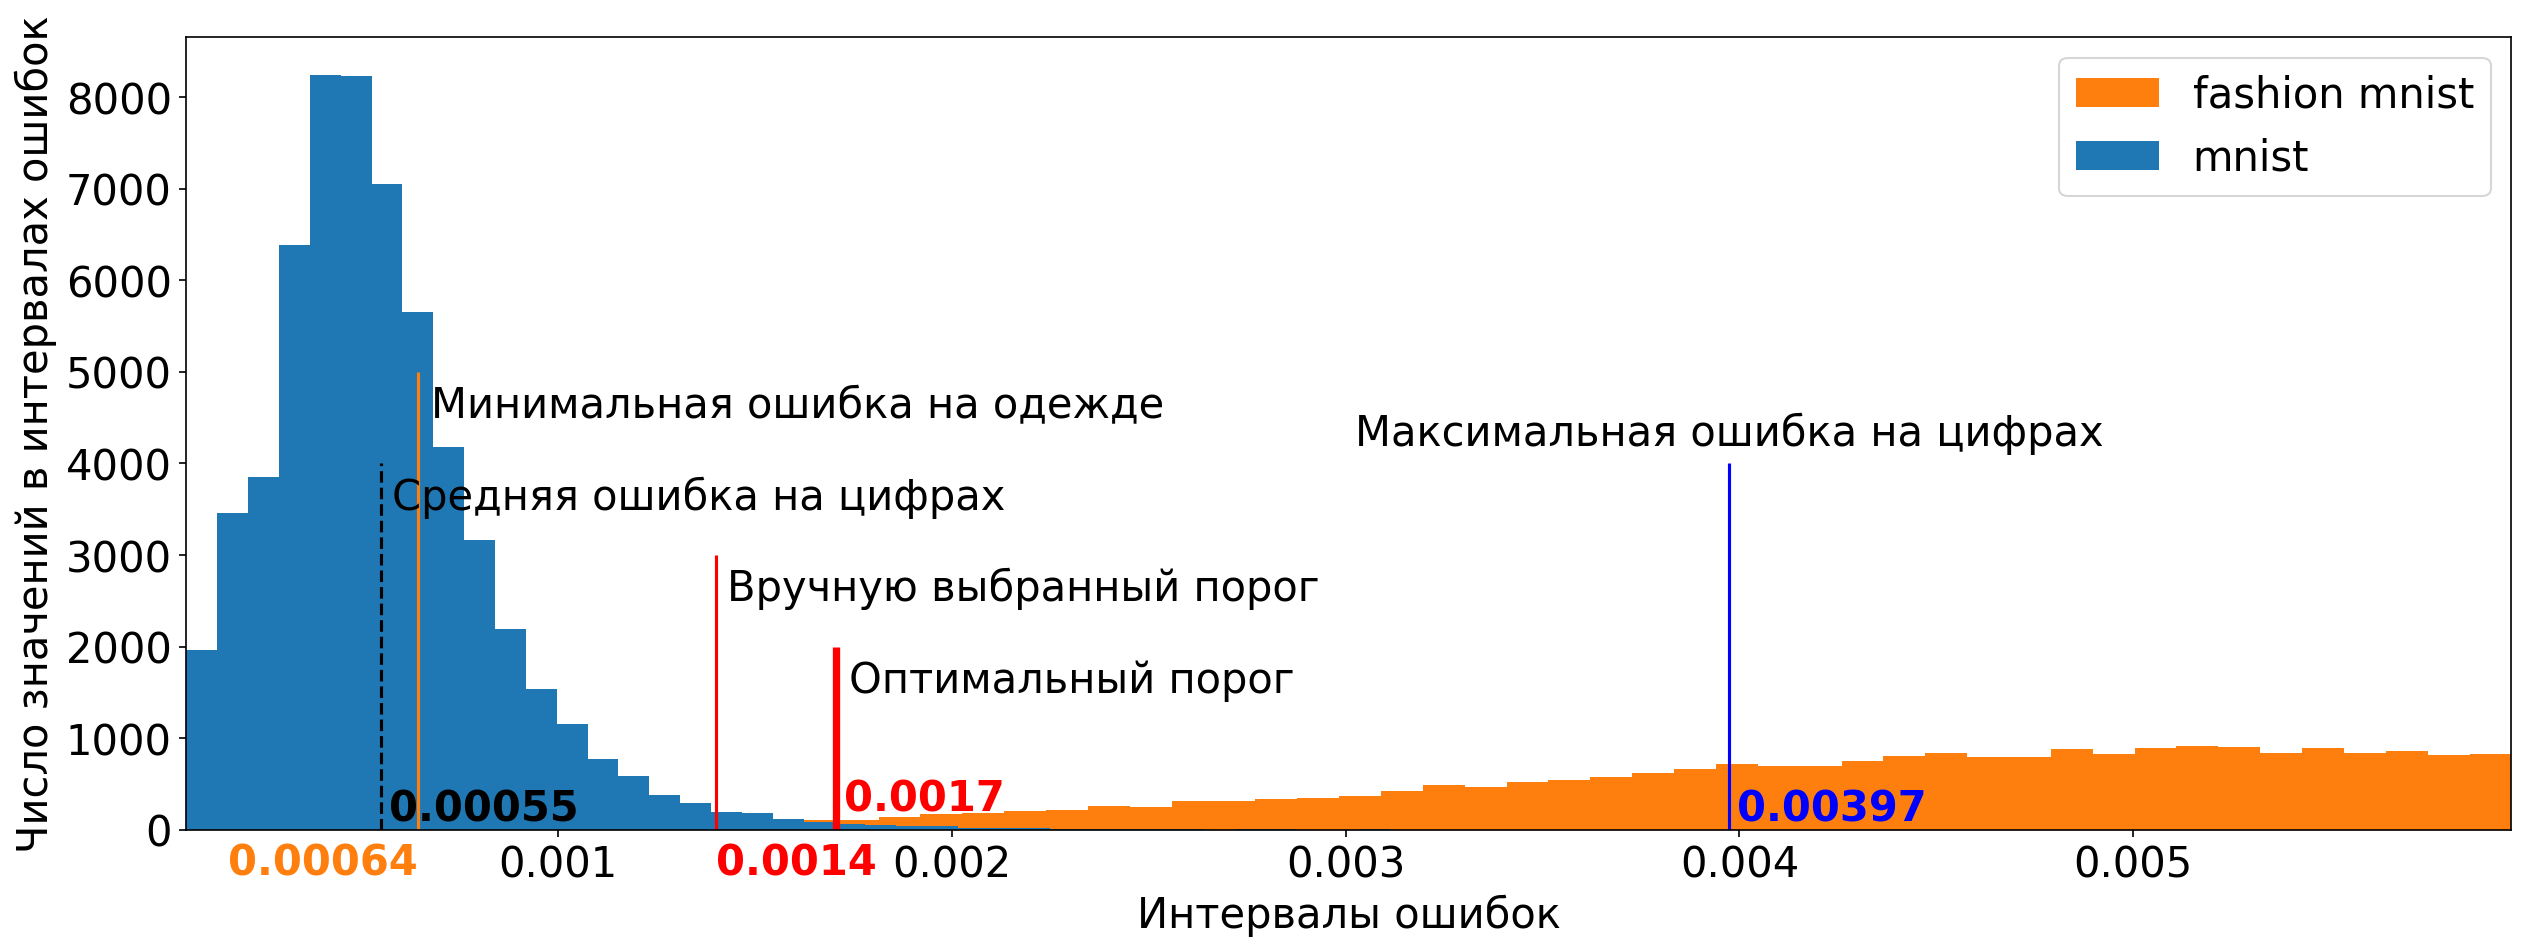

In [ ]:
show_hist(threshold_optimized=threshold_optimized)

Как видите из результатов, вы вручную почти угадали оптимальный порог, но перебрать 1 000 значений самостоятельно было бы трудно. Функция, которую вы написали, ускорила процесс. 

Подобранный оптимальный порог не решил задачу полностью. То есть какие-то изображения одежды не определяются как выбросы и наоборот – некоторые цифры определяются как выбросы. Но что так и будет было понятно еще на этапе вычисления ошибок на цифрах и одежде. То есть эти два множества одномерных точек на оси ошибок пересекались, из-за чего их нельзя разделить точкой, как делали мы. Но тем не менее, оптимальный порог разделил эти два множества друг от друга с точностью $>99\%$. В подавляющем большенстве случаев на практике такой результат удовлетворит заказчика.

Разобравшись, как находить выбросы, посмотрите, что происходит со скрытым слоем во время обучения автокодировщика.


##Визуализация динамики латентного пространства в процессе обучения

В данном разделе вы проведете наглядный эксперимент, который позволит лучше понять латентное пространство автокодировщика. На этот раз не нужно стремиться за точностью. Смысл эксперимента состоит в исследовании скрытого пространства.

###Создание и обучение автокодировщика

Опишите функцию создания автокодировщика. Как вы уже знаете, особенность данной структуры в том, что она разделена на две части: энкодер и декодер. Создаете максимально простую архитектуру, возьмите по одному слою **Dense** в каждую из частей:
1. Энкодер:
    * вход с размерностью;
    * выпрямитель массива;
    * полносвязный слой.
2. Декодер:
    * вход с размерностью;
    * полносвязный слой;
    * изменение размерности.


Почему бы не воспользоваться предыдущей моделью автокодировщика?
> На это есть две причины: 
1. В этом эксперименте будет визуализация объектов в латентном пространстве в ходе обучения. В предыдущей модели вы могли заметить, что форма тензоров в латентном пространстве была (7, 7, 64). Это соответсвует $7 \cdot 7 \cdot 64 = 3136$ измерениям. Но лучшее количество измерений для простой и понятной визуализации – два. Одно измерение будет не так наглядно, а три и более уже неоправданно сложнее для восприятия.
2.  Для визуализации понадобятся значения внутри латентного пространства. А для этого нужен выход энкодера. А для этого необходима возможность воспользоваться энкодером без декодера. Такой возможности не было в предыдущей модели. Такая возможность будет в следующей архитектуре.

Чтобы объединить энкодер и декодер в одну сеть, используйте структуру `Model(input_img, decoder(encoder(input_img))`, где:
* `input_img` – вход автокодировщика;
* `decoder(encoder(input_img))` – выход автокодировщика, состоящий из результата декодера, которому на вход подается результат энкодера от входа автокодировщика. Получается такая матрешка из включений.


In [ ]:
# Функция сборки автокодировщика по частям
def create_dense_ae(in_shape, latent_dim): 
    # ЭНКОДЕР
    # Вход
    input_img = Input(in_shape)

    # Вспомогательный слой смены формы
    flat_img = Flatten()(input_img)    

    # Кодированное полносвязным слоем представление (вектор латентного пространства)
    encoded = Dense(latent_dim, activation='relu')(flat_img)    

    # ДЕКОДЕР
    # Вход
    input_encoded = Input(shape=(latent_dim,))

    # Раскодированное другим полносвязным слоем изображение в виде плоского вектора
    flat_decoded = Dense(in_shape[0] * in_shape[1], activation='sigmoid')(input_encoded) 
    
    # Приведение формы раскодированных данных к форме входа
    decoded = Reshape(in_shape)(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать, как и слои
    encoder = Model(input_img, encoded, name='encoder')
    decoder = Model(input_encoded, decoded, name='decoder')

    # Построение модели автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

    # Возврат трех собранных моделей
    return encoder, decoder, autoencoder

Теперь энкодер и декодер – небольшие НС, которые входят в состав одной НС-автокодировщика. Кстати, для этого мы как раз и использовали Model API, а не Sequential API. 

In [ ]:
# Создание трех моделей - составных частей автокодировщика и самого автокодировщика
encoder, decoder, autoencoder = create_dense_ae(in_shape=x_train_mnist.shape[1:3], latent_dim=2)

Так как функция возвращала все три модели, теперь можно создать их одной строкой. Посмотрите, как они выглядят.

Схема энкодера:


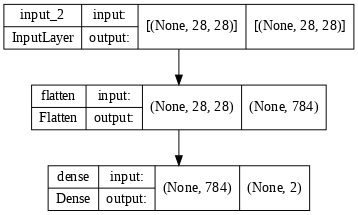

In [ ]:
print('Схема энкодера:')
utils.plot_model(encoder, show_shapes=True, dpi=70)

Схема декодера:


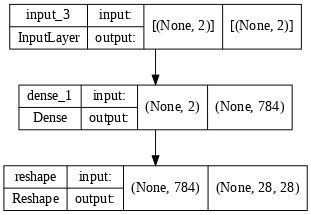

In [ ]:
print('Схема декодера:')
utils.plot_model(decoder, show_shapes=True, dpi=70)

Схема автокодировщика:


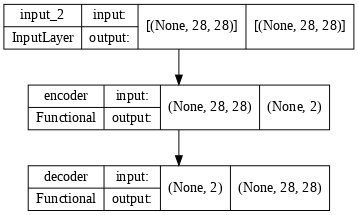

In [ ]:
print('Схема автокодировщика:')
utils.plot_model(autoencoder, show_shapes=True, dpi=70)

##### Как получается, что из вектора меньшей размерности Z (2) получается вектор большей размерности Х (аж 784)?

Тут нужно просто понимать, как работает Dense слой – линейный слой нейросети.
Если коротко, то на вход линейного слоя подается вектор $x = (x_1, x_2)^T$. Допустим в нем 3 нейрона с весами W. Тогда выход будет выглядеть так:
$$ W^T x = \left(
    \begin{array}{cccc}
      w_{11} & w_{12} \\
      w_{21} & w_{22}\\
      w_{31} & w_{32} \\
    \end{array}
  \right)
    \cdot 
  \left(
    \begin{array}{c}
      x_1 \\
      x_2 \\
    \end{array}
  \right) = 
  \left(
    \begin{array}{cccc}
      w_{11}x_1 + w_{12}x_2 \\
      w_{21}x_1 + w_{22}x_2 \\
      w_{31}x_1 + w_{32}x_2 \\
    \end{array}
  \right)
$$
Размер последнего вектора равен 3. Таким образом из вектора $x$ размерности 2 получен вектор большей размерности 3. Аналогично можно получить на выходе размер хоть 10, хоть 10000, хоть 784.


###Визуальное представление точек латентного пространства

Посмотрите случайное изображение из тренировочной выборки.


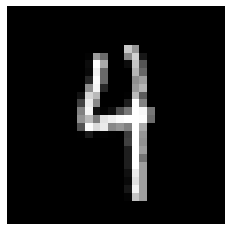

In [ ]:
# Выбор случайного изображения из тренировочной выборки и показ его
test_img = x_test_mnist[np.random.randint(len(x_test_mnist))] 
plt.imshow(test_img.reshape(x_train_mnist.shape[1:3]), cmap='gray')
plt.axis('off')
plt.show()

Чтобы понять, как работает скрытое пространство, сделайте предсказание только одного энкодера и выведите на графике координаты данной точки.


[[0.        0.3436322]]


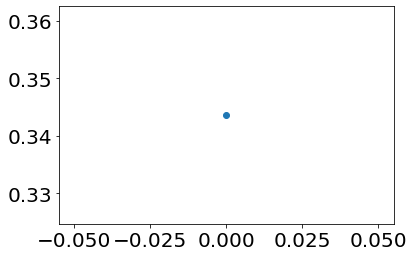

In [ ]:
# Получение предсказания энкодера (двумерная точка в латентном пространстве)
point = encoder.predict(test_img[None,...]) 

# Вывод координат точки в числах и на графике
print(point)
scatter = plt.scatter(point[0,0], point[0,1]) 
plt.show()

Теперь сделайте то же самое, но для всех цифр 5, 7, 9 из набора данных MNIST.

Для этого при помощи маски вы создали новые массивы с данными, в которые включены только необходимые цифры. Сделайте предсказание энкодера по всем значениям и выведите результаты на график. Обратите внимание на два параметра:
* **c** отвечает за цвет, в данном случае вы передаете ему информацию, что точки должны быть раскрашены в 3 цвета;
* **alpha** отвечает за прозрачность точек, где 0 – прозрачные, 1 – непрозрачные.


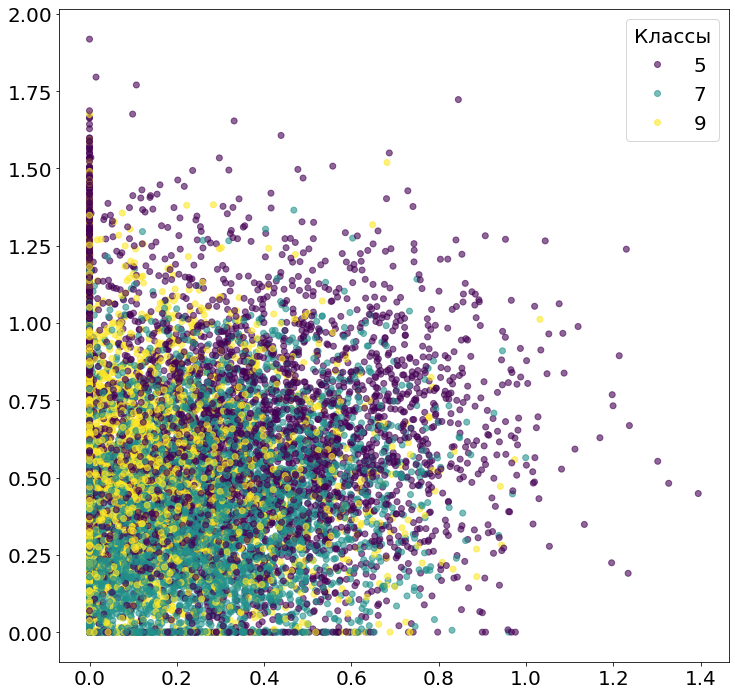

In [ ]:
# Задание цифр для визуализации латентного пространства
numbers = [5, 7, 9]
# Создание маски по выбранным цифрам
mask = np.array([(i in numbers) for i in y_train_mnist])
# Отбор примеров заданных цифр по маске из тренировочной выборки
new_x_train = x_train_mnist[mask]
new_y_train = y_train_mnist[mask]

# Получение предсказания энкодера для отобранных примеров 
# и отрисовка точек латентного пространства на графике
plt.figure(figsize=(12,12))
predict = encoder.predict(new_x_train) 
scatter = plt.scatter(predict[:,0,],predict[:,1], c=new_y_train, alpha=0.6) 
legend2 = plt.legend(*scatter.legend_elements(),loc="upper right", title="Классы") 
plt.show()

Разобравшись с одним состоянием, посмотрите, как это выглядит в динамике.


###Визуализация динамики латентного пространства в процессе обучения автокодировщика

Так как динамику изменения скрытого слоя может дать только обучение НС, то для этого вы напишите **callback**, который будет вызываться в конце каждой эпохи. Для начала выведите строки с информацией об эпохе и ошибке на этой эпохе. Затем повторите то же самое, когда смотрели состояние скрытого пространства в статике. Сделайте предсказание по энкодеру, выведите график и сохраните его.

Затем при помощи `LambdaCallback(on_epoch_end=ae_on_epoch_end)` укажите, что функция будет вызываться в конце каждой эпохи.

In [ ]:
# Назначение функции-коллбэка в конце эпохи
def ae_on_epoch_end(epoch, logs):
    print('________________________')  
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')  
    
    # Получение картинки латентного пространства в конце эпохи и запись в файл
    plt.figure(figsize=(12,12))
    predict = encoder.predict(new_x_train)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=new_y_train, alpha=0.6)
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')
    plt.savefig(f'image{str(epoch)}.jpg')
    plt.show()

ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Теперь перейдите к обучению. 

Скомпилируйте НС, и в этот раз возьмите цифры 0, 1, 3. Подготовьте выборки и обозначьте количество эпох.

При обучении НС укажите, что данные из выборки необходимо перемешать `shuffle=True` и callback выступает в роли функции, которую вы прописали ранее: `callbacks = [ae_callback]`.

In [ ]:
# Компиляция модели с выбранным оптимизатором и функцией потерь 
autoencoder.compile(optimizer='adam', loss='mse') 

# Выбор визуализируемых классов (цифр) и формирование подвыборок для них
numbers = [0, 1, 3]
epochs = 50
mask = np.array([(i in numbers) for i in y_train_mnist])
new_x_train = x_train_mnist[mask]
new_y_train = y_train_mnist[mask]

# Обучение автокодировщика с протоколом работы
autoencoder.fit(new_x_train, new_x_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                callbacks = [ae_callback],
                verbose=0)

Когда обучение НС закончено, возьмите любую точку из скрытого пространства, подайте ее в декодер и посмотрите на результат. Выше выведены два примера различных точек, взятых случайным образом.

In [ ]:
# Выбор некоторой точки в латентном пространстве
point = np.array([[17, 12]])

# Получение восстановленного изображения при помощи обученного декодера
result = decoder.predict(point)
print(result.shape)

(1, 28, 28)


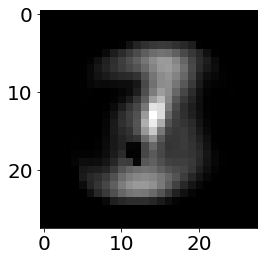

In [ ]:
# Вывод на экран полученного изображения
plt.imshow(result[0].reshape(result.shape[1:3]), cmap='gray') 
plt.show()

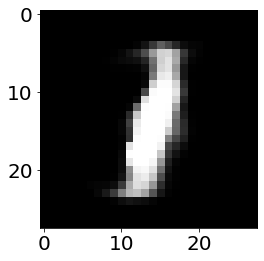

In [ ]:
# Попытка с другой точкой
point = np.array([[23, 56]])
result = decoder.predict(point)
plt.imshow(result[0].reshape(result.shape[1:3]), cmap='gray') 
plt.show()

При помощи библиотеки **imageio** создайте анимацию динамики скрытого пространства, используя графики, которые вы сохраняли в callback.
Подключите модуль для показа gif и выведите ее на экран. Так выглядит изменение латентного пространства в автокодировщике.

In [ ]:
import imageio                            # Подключение библиотеки для сборки анимации
images = []                               # Пустой список под изображения для gif
for i in range(epochs):                   # Покадровая сборка gif-анимации
    images.append(imageio.imread(f'image{str(i)}.jpg')) 
imageio.mimsave('AE.gif', images)         # Сохранение анимации

In [ ]:
from IPython.display import Image         # Подключаем модуля для показа gif в ячейке
Image(open('AE.gif','rb').read())         # Показ анимации

Суть автокодировщика состоит в восстановлении исходного изображения из вектора скрытого пространства. Для этого нужно, чтобы кодировщик правильно выделил ключевые признаки, декодировщик умел восстановить из этих признаков само изображение. Также нужно, конечно, достаточно сложное скрытое пространство, способное вместить эти ключевые признаки. 

В нашем случае в скрытом пространстве всего 2 измерения. Соответственно в них кодировщик пытается выделить 2 самых ярких, самых главных признака датасета. Под признаками имеется ввиду не одно из чисел изображения. Признак в данном случае – это абстрактное понятие, известное лишь самому автокодировщику.

 Как видно из гифки, по этим двум признакам уже можно различить классы. По крайней мере большую часть изображений этих трех классов друг от друга. 

## Итог

Вы прошли первый из двух практических ноутбуков по теме **Автокодировщики**. <br>
Что вы прошли:
* вы построили модель автокодировщика;
* обучили его на картинках цифр;
* узнали, как ведет себя этот автокодировщик на картинках с одеждой, которые ранее не видел;
* написали алгоритм подбора оптимального порога, отделяющего выброс от нормальных данных по значению ошибки;
* создали вторую модель автокодировщика, но уже с гораздо меньшим скрытым пространством;
* обучили его на той же базе цифр;
* пронаблюдали, как при этом меняется представление нескольких цифр в латентном пространстве.

На этом первая практика подошла к концу. Поздравляем с прохождением!

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1mgQaPN1eqhzNpTYTqbbXZHmolI7d2yll?usp=sharing)

2. Практика 1

3. [Практика 2](https://colab.research.google.com/drive/1sLGgmGkPLr5-ZLJM6vNLs7rQH29rbSUZ?usp=sharing)
